
## Meta-Learning for Linear Regression Parameter Initialization

**The core idea: Learn how to initialize 'a' and 'b' parameters based on dataset statistical characteristics.**

**this way, we will need way less (or zero) iterations for convevrgence as compared to random initialization each time.**


### Project breakdown:

1. Dataset Generation:
- Generate multiple synthetic datasets with different:
  * Slopes (a values)
  * Intercepts (b values)
  * Noise levels
  * Data ranges
  * Sample sizes

2. Feature Extraction from Datasets:
Extract meta-features like:
- Mean/std of x values
- Mean/std of y values
- Correlation coefficient
- Data range
- Sample size
- Signal-to-noise ratio estimates
- Basic statistical moments (skewness, kurtosis)

3. Meta-Learning Task:
- Create a meta-dataset where:
  * Inputs = meta-features of each dataset
  * Outputs = optimal (or good) initial values for 'a' and 'b'
- Train a meta-model to predict good initialization values

4. Evaluation:
Compare three approaches:
- Random initialization
- Fixed initialization (like a=1, b=0)
- Meta-learned initialization

Measure:
- Number of iterations to converge
- Final loss value
- Convergence stability

This project helps students understand:
- The importance of initialization
- Dataset characteristics
- Meta-features design
- The relationship between data properties and model parameters



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# [Previous functions remain the same until train_meta_learner]
def generate_dataset(size=20, true_a=1.0, true_b=2.0, x_range=(0, 10), noise_std=0.5):
    X = np.random.uniform(x_range[0], x_range[1], size)
    y = true_a * X + true_b + np.random.normal(0, noise_std, size)
    return X, y

def extract_meta_features(X, y):
    features = {
        'x_mean': np.mean(X),
        'x_std': np.std(X),
        'y_mean': np.mean(y),
        'y_std': np.std(y),
        'correlation': np.corrcoef(X, y)[0, 1],
        'x_range': np.max(X) - np.min(X),
        'y_range': np.max(y) - np.min(y),
        'sample_size': len(X),
        'x_skew': np.mean(((X - np.mean(X))/np.std(X))**3),
        'y_skew': np.mean(((y - np.mean(y))/np.std(y))**3)
    }
    return features

In [3]:
def train_linear_regression(X, y, a_init, b_init, epochs=500, learning_rate=0.005):
    a = a_init
    b = b_init
    losses = []
    ## x --> model --> ypred -----> MSE(ypred, yreelle) ----> GD (1. g, 2. optimisation)
    for i in range(epochs):
        y_pred = a*X + b

        loss = np.mean((y - y_pred)**2)
        losses.append(loss)

        Da = -2*np.mean(X*(y - y_pred))
        Db = -2*np.mean(y - y_pred)

        a = a - learning_rate*Da
        b = b - learning_rate*Db

    return a, b, losses

def generate_meta_dataset(n_datasets=100):
    meta_features_list = []
    optimal_params_list = []

    for _ in range(n_datasets):
        true_a = np.random.uniform(0.1, 5.0)
        true_b = np.random.uniform(-3.0, 3.0)
        noise_std = np.random.uniform(0.1, 1.0)

        X, y = generate_dataset(size=1000 , true_a=true_a, true_b=true_b, noise_std=noise_std)
        meta_features = extract_meta_features(X, y)

        meta_features_list.append(list(meta_features.values()))
        optimal_params_list.append([true_a, true_b])

    return np.array(meta_features_list), np.array(optimal_params_list)

In [4]:
# New Meta-Learner class with multiple models
class AdvancedMetaLearner:
    def __init__(self, model_type='rf'):
        self.model_type = model_type
        self.scaler = StandardScaler()

        if model_type == 'rf':
            self.model_a = RandomForestRegressor(n_estimators=100, max_depth=10)
            self.model_b = RandomForestRegressor(n_estimators=100, max_depth=10)
        elif model_type == 'svr':
            self.model_a = SVR(kernel='rbf', C=1.0, epsilon=0.1)
            self.model_b = SVR(kernel='rbf', C=1.0, epsilon=0.1)

    def train(self, meta_features, optimal_params):
        # Scale features
        X_scaled = self.scaler.fit_transform(meta_features)

        # Train separate models for a and b
        self.model_a.fit(X_scaled, optimal_params[:, 0])
        self.model_b.fit(X_scaled, optimal_params[:, 1])

    def predict(self, meta_features):
        # Scale features
        X_scaled = self.scaler.transform(meta_features.reshape(1, -1))

        # Predict a and b
        a_pred = self.model_a.predict(X_scaled)[0]
        b_pred = self.model_b.predict(X_scaled)[0]

        return a_pred, b_pred

In [5]:
# Generate larger meta-dataset
meta_features, optimal_params = generate_meta_dataset(n_datasets=500)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    meta_features, optimal_params, test_size=0.2, random_state=42
)

In [6]:
# Train both types of meta-learners
rf_meta_learner = AdvancedMetaLearner(model_type='rf')
svr_meta_learner = AdvancedMetaLearner(model_type='svr')

rf_meta_learner.train(X_train, y_train)
svr_meta_learner.train(X_train, y_train)

# Test on a new dataset
X_test, y_test = generate_dataset(true_a=2.5, true_b=1.5)


In [7]:
# Extract meta-features from test dataset
test_meta_features = np.array(list(extract_meta_features(X_test, y_test).values()))

# Get meta-learned initializations
a_init_rf, b_init_rf = rf_meta_learner.predict(test_meta_features)
a_init_svr, b_init_svr = svr_meta_learner.predict(test_meta_features)

# Train with different initializations
# 1. Random initialization
a_random, b_random, losses_random = train_linear_regression(X_test, y_test,
                                                          random.random(), random.random())

# 2. RF meta-learned initialization
a_rf, b_rf, losses_rf = train_linear_regression(X_test, y_test,
                                               a_init_rf, b_init_rf)

# 3. SVR meta-learned initialization
a_svr, b_svr, losses_svr = train_linear_regression(X_test, y_test,
                                                  a_init_svr, b_init_svr)


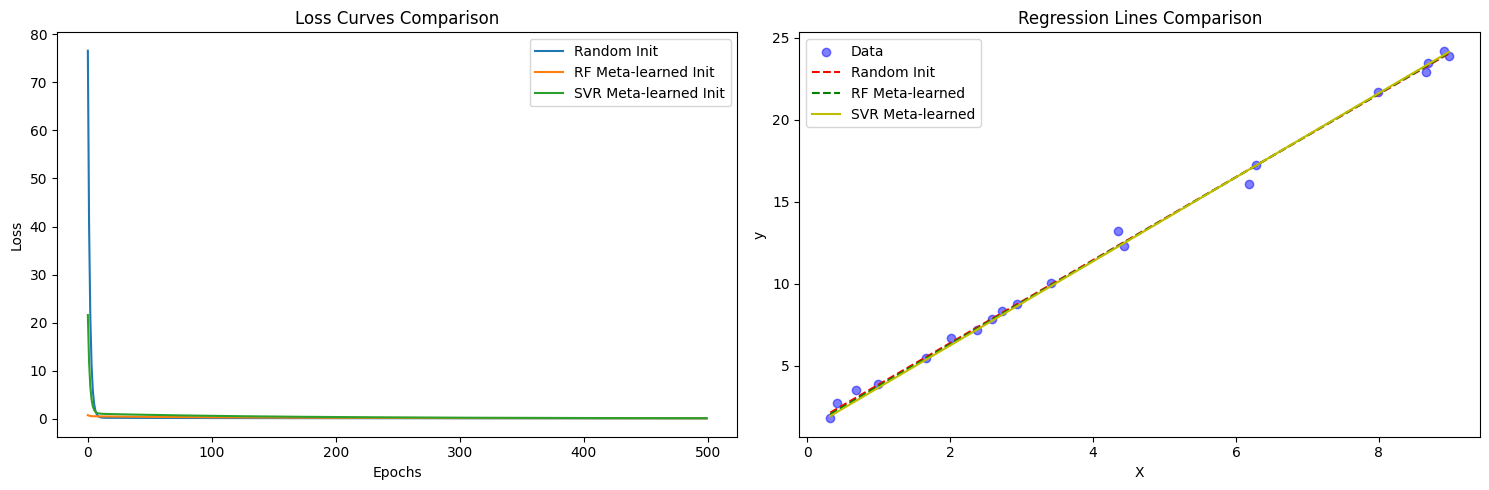


Initialization Values:
Random: a=0.510, b=0.149
RF Meta-learned: a=2.597, b=0.308
SVR Meta-learned: a=1.933, b=-0.406

Final Parameters:
Random: a=2.527, b=1.341
RF Meta-learned: a=2.543, b=1.239
SVR Meta-learned: a=2.561, b=1.125


In [8]:
# Plotting results
plt.figure(figsize=(15, 5))

# Plot 1: Loss curves comparison
plt.subplot(1, 2, 1)
plt.plot(losses_random, label='Random Init')
plt.plot(losses_rf, label='RF Meta-learned Init')
plt.plot(losses_svr, label='SVR Meta-learned Init')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves Comparison')

# Plot 2: Final regression lines
plt.subplot(1, 2, 2)
plt.scatter(X_test, y_test, color='blue', alpha=0.5, label='Data')
x_line = np.linspace(min(X_test), max(X_test), 100)
plt.plot(x_line, a_random*x_line + b_random, 'r--', label='Random Init')
plt.plot(x_line, a_rf*x_line + b_rf, 'g--', label='RF Meta-learned')
plt.plot(x_line, a_svr*x_line + b_svr, 'y-', label='SVR Meta-learned')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title('Regression Lines Comparison')

plt.tight_layout()
plt.show()

# Print initialization values and final parameters
print("\nInitialization Values:")
print(f"Random: a={random.random():.3f}, b={random.random():.3f}")
print(f"RF Meta-learned: a={a_init_rf:.3f}, b={b_init_rf:.3f}")
print(f"SVR Meta-learned: a={a_init_svr:.3f}, b={b_init_svr:.3f}")

print("\nFinal Parameters:")
print(f"Random: a={a_random:.3f}, b={b_random:.3f}")
print(f"RF Meta-learned: a={a_rf:.3f}, b={b_rf:.3f}")
print(f"SVR Meta-learned: a={a_svr:.3f}, b={b_svr:.3f}")

## Next ?


1) you do the same, but now for other models (not linear regression)
maybe :

     * multiple output regression
     * logistic regression
     * simple neural net (less than 20 neurons)
     * etc.


